<img src='img/logo.png' alt='Drawing' style='width:2000px;'/>

# <font color=blue>4. 2D Frame Systems</font>

| | |
|-|-|
| | |
| <img src='img/frame.png' alt='Drawing' style='height:250px;'/>|
| | |

| | |
|-|-|
| | |
| <img src='img/fiber_sec_1.png' alt='Drawing' style='height:250px;'/>| <img src='img/fiber_sec_3.png' alt='Drawing' style='height:250px;'/>|
| | |

## <font color=blue>4.1. Required Libraries</font>
Although the only library required to perform structural analysis we can make use of other libraries to perform other tasks. This is the nicest thing about Python!
<font color=red><div style="text-align: right"> **Documentation for**  
[**`openseespy`**](https://openseespydoc.readthedocs.io/en/latest/)  
[**`ops_vis.plot_model`**](https://openseespydoc.readthedocs.io/en/latest/src/ops_vis.html)  
[**`Get_Rendering`**](https://openseespydoc.readthedocs.io/en/latest/src/plotcmds.html)  
[**`numpy`**](https://docs.scipy.org/doc/numpy/)  
[**`matplotlib.pyplot`**](https://matplotlib.org/api/pyplot_api.html)</div></font>

In [1]:
# import libraries 
# ------------------------------------------------------------------------
# A library to use OpenSees via Python
import openseespy.opensees as ops

# A visulization package for OpenSees in Python
import openseespy.postprocessing.ops_vis as opsv

# A visulization package for OpenSees in Python
import openseespy.postprocessing.Get_Rendering as opsplt # another visulization package for opensees

# A library provides high-performance vector, matrix and higher-dimensional data structures for Python
import numpy as np 

# A Library to visualize data from Python
import matplotlib.pyplot as plt 

# A command required to print the figures on notebook
%matplotlib inline 

## <font color=blue>4.2. Unit Definitions</font>
We can use any units in definition of parameters as long as we properly define other unit measures. In our examples we will use meters (m) for displacements, kiloNewtons (kN) for forces, and seconds (sec) for time as basic unit definitions. In other words, the results obtained from OpenSeesPy will be in these units.

In [2]:
# Define units
# ------------------------------------------------------------------------
# Basic Units
m = 1.0
kN = 1.0
sec = 1.0

# Length
mm = m / 1000.0
cm = m / 100.0
inch = 25.4 * mm
ft = 12.0 * inch

# Force
N = kN / 1000.0
kips = kN * 4.448221615
lb = kips / 1.0e3

# Stress (kN/m2 or kPa)
Pa = N / (m ** 2)
kPa = Pa * 1.0e3
MPa = Pa * 1.0e6
GPa = Pa * 1.0e9
ksi = 6.8947573 * MPa
psi = 1e-3 * ksi

# Mass - Weight
tonne = kN * sec ** 2 / m
kg = N * sec ** 2 / m
lb = psi*inch**2

# Gravitational acceleration
g = 9.81*m/sec**2

# Time
min = 60*sec
hr = 60*min

## <font color=blue>4.3. Linear Elastic Frame Example</font>
### <font color=blue>4.3.1. Definition of the Numerical Model</font>
We are going to generate a 2D elastic frame model. In particular, we are going to use [Elastic Timoshenko Beam Column Element](https://openseespydoc.readthedocs.io/en/latest/src/ElasticTimoshenkoBeam.html). Differently from [Elastic Beam Column Element](https://openseespydoc.readthedocs.io/en/latest/src/elasticBeamColumn.html) it can account for shear deformations as well. We can generate a clean model whenever we call the specific function for it. Hence, we do not need to write same lines again and again.
<font color=red><div style="text-align: right"> **Documentation for**    
[**`ops.model`**](https://openseespydoc.readthedocs.io/en/latest/src/model.html)
[**`ops.wipe`**](https://openseespydoc.readthedocs.io/en/latest/src/wipe.html)    
[**`ops.node`**](https://openseespydoc.readthedocs.io/en/latest/src/node.html)
[**`ops.mass`**](https://openseespydoc.readthedocs.io/en/latest/src/mass.html)
[**`ops.fix`**](https://openseespydoc.readthedocs.io/en/latest/src/fix.html)    
[**`ops.geomTransf`**](https://openseespydoc.readthedocs.io/en/latest/src/geomTransf.html)
[**`ops.element`**](https://openseespydoc.readthedocs.io/en/latest/src/element.html#)    
[**`ops.timeSeries`**](https://openseespydoc.readthedocs.io/en/latest/src/timeSeries.html)
[**`ops.pattern`**](https://openseespydoc.readthedocs.io/en/latest/src/plainPattern.html)    
[**`ops.load`**](https://openseespydoc.readthedocs.io/en/latest/src/load.html)
[**`ops.eleload`**](https://openseespydoc.readthedocs.io/en/latest/src/eleload.html)</div></font>

In [3]:
def generate_elastic_model():
    """
    Procedure to define the elastic numerical model of 2D frame example
    Args:
        None
    Returns:
        None
    """
    # Parameters for overall model geometry
    # ------------------------------------------------------------------------
    LBeam = 360.0*inch 
    LCol = 144.0*inch 

    # Section properties
    # ------------------------------------------------------------------------
    kv = 5/6                          # Shape factor for rectangular sections
    kBeam = 0.5                       # Flexural stiffness modification factor for beams
    kCol = 0.8                        # Flexural stiffness modification factor for columns
    
    HCol = 28*inch                    # Column depth -- perpendicular to bending axis
    BCol = HCol                       # Column width -- parallel to bending axis
    HBeam = 24*inch                   # Beam depth -- perpendicular to bending axis
    BBeam = 18*inch                   # Beam width -- parallel to bending axis
    
    Acol = HCol*BCol                  # Cross-sectional area of columns
    Icol = kCol*1/12*BCol*HCol**3     # Effective moment of inertia of columns
    Avcol = kv*Acol                   # Shear area for beams (Timoshenko Elements)
    Abeam = BBeam*HBeam               # Cross-sectional area of beams
    Ibeam = kBeam*1/12*BBeam*HBeam**3 # Gross moment of inertia of beams
    Avbeam = kv*Abeam                 # Shear area for beams (Timoshenko Elements)

    # Material properties
    # ------------------------------------------------------------------------
    fc = 4.0*ksi                    # Nominal concrete compressive strength
    Ec = 5000*MPa*(fc/MPa)**0.5     # Young's modulus
    nu = 0.2                        # Poisson's ratio
    Gc = Ec/(2*(1+nu))              # Shear modulus
    
    # Structural Loads
    # ------------------------------------------------------------------------
    PCol = 0.05*fc*HCol*BCol  # Point loads on beam column joints
    wBeam = 0.04*fc*HCol*BCol/LBeam # Distributed loads on beams

    # clear memory of past model definitions
    # ------------------------------------------------------------------------
    ops.wipe('all')                                    
    
    # Create ModelBuilder (with two-dimensions and 3 DOF/node)
    # ------------------------------------------------------------------------
    ops.model('basic', '-ndm', 2, '-ndf', 3)    

    # Create nodes
    # ------------------------------------------------------------------------
    ops.node(1, 0.0, 0.0)
    ops.node(2, LBeam, 0.0)
    ops.node(3, 0.0, LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(4, LBeam, LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(5, 0.0, 2*LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(6, LBeam, 2*LCol, '-mass', PCol/g, PCol/g, 0.0)

    # Alternatively, you can define nodal masses as follows
    # ------------------------------------------------------------------------
    # ops.mass(3, PCol/g, PCol/g, 0.0)
    # ops.mass(4, PCol/g, PCol/g, 0.0)
    # ops.mass(5, PCol/g, PCol/g, 0.0)
    # ops.mass(6, PCol/g, PCol/g, 0.0)
    
    # Single-point constraints at base of columns
    # ------------------------------------------------------------------------
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 1, 1, 1)

    # Geometric transformations
    # ------------------------------------------------------------------------
    ColTransfTag = 1
    BeamTransfTag = 2
    ops.geomTransf('Linear', ColTransfTag)
    ops.geomTransf('Linear', BeamTransfTag)
    
    # Define column elements
    # ------------------------------------------------------------------------
    # ops.element('elasticBeamColumn', 11, 1, 3, Acol, Ec, Icol, ColTransfTag)
    # ops.element('elasticBeamColumn', 12, 2, 4, Acol, Ec, Icol, ColTransfTag)
    # ops.element('elasticBeamColumn', 21, 3, 5, Acol, Ec, Icol, ColTransfTag)
    # ops.element('elasticBeamColumn', 22, 4, 6, Acol, Ec, Icol, ColTransfTag)
    ops.element('ElasticTimoshenkoBeam', 11, 1, 3, Ec, Gc, Acol, Icol, Avcol, ColTransfTag)
    ops.element('ElasticTimoshenkoBeam', 12, 2, 4, Ec, Gc, Acol, Icol, Avcol, ColTransfTag)
    ops.element('ElasticTimoshenkoBeam', 21, 3, 5, Ec, Gc, Acol, Icol, Avcol, ColTransfTag)
    ops.element('ElasticTimoshenkoBeam', 22, 4, 6, Ec, Gc, Acol, Icol, Avcol, ColTransfTag)
    
    # Define beam elments
    # ------------------------------------------------------------------------
    # ops.element('elasticBeamColumn', 13, 3, 4, Abeam, Ec, Ibeam, BeamTransfTag,'-mass', wBeam/g)
    # ops.element('elasticBeamColumn', 23, 5, 6, Abeam, Ec, Ibeam, BeamTransfTag,'-mass', wBeam/g)
    ops.element('ElasticTimoshenkoBeam', 13, 3, 4, Ec, Gc, Abeam, Ibeam, Avbeam, BeamTransfTag,'-mass', wBeam/g)
    ops.element('ElasticTimoshenkoBeam', 23, 5, 6, Ec, Gc, Abeam, Ibeam, Avbeam, BeamTransfTag,'-mass', wBeam/g)

    # Create a Plain load pattern with a Linear TimeSeries
    ## ------------------------------------------------------------------------
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)

    # Create nodal loads at nodes
    # ------------------------------------------------------------------------
    ops.load(3, 0.0, -PCol, 0.0)
    ops.load(4, 0.0, -PCol, 0.0)
    ops.load(5, 0.0, -PCol, 0.0)
    ops.load(6, 0.0, -PCol, 0.0) 
    
    # Apply distributed loading along the beam
    # ------------------------------------------------------------------------
    ops.eleLoad('-ele', 13, '-type', '-beamUniform', -wBeam, 0)
    ops.eleLoad('-ele', 23, '-type', '-beamUniform', -wBeam, 0)

## <font color=blue>4.3.2. Display of the Numerical Model</font>
In order to visualize OpenSees models we can create our own functions or use pre-existing packages (Get_Rendering, ops_vis) written by other researchers. These packages can be used to visualize even the results of structural analysis.
<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops_vis.plot_model`**](https://openseespydoc.readthedocs.io/en/latest/src/ops_vis_plot_model.html)  
[**`Get_Rendering.plot_model`**](https://openseespydoc.readthedocs.io/en/latest/src/plot_model.html)
</div></font>

No Model_ODB specified, trying to get data from the active model.
2D model


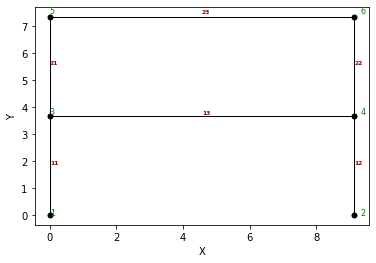

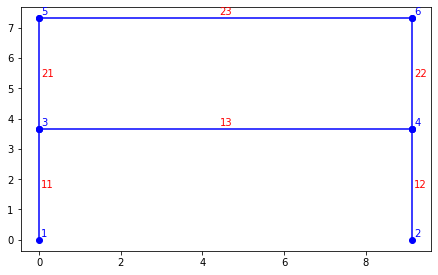

In [4]:
# Build the numerical model
# ------------------------------------------------------------------------
generate_elastic_model()

# Display the model with tag lebels
# ------------------------------------------------------------------------
opsplt.plot_model('nodes','elements') # Using Get_Rendering package
opsv.plot_model()                     # Using ops_vis package

## <font color=blue>4.3.2. Gravity Analysis</font>
The same way we have done earlier on it is possible to create a separate function to perform gravity analysis. Then, even if the numerical model changes we can use the function we have written for any other model.
<font color=red><div style="text-align: right"> **Documentation for**    
[**`ops.test`**](https://openseespydoc.readthedocs.io/en/latest/src/test.html)
[**`ops.algorithm`**](https://openseespydoc.readthedocs.io/en/latest/src/algorithm.html)
[**`ops.numberer`**](https://openseespydoc.readthedocs.io/en/latest/src/numberer.html)
[**`ops.system`**](https://openseespydoc.readthedocs.io/en/latest/src/system.html)  
[**`ops.constraints`**](https://openseespydoc.readthedocs.io/en/latest/src/constraints.html)
[**`ops.integrator`**](https://openseespydoc.readthedocs.io/en/latest/src/integrator.html)
[**`ops.analysis`**](https://openseespydoc.readthedocs.io/en/latest/src/analysis.html)
[**`ops.analyze`**](https://openseespydoc.readthedocs.io/en/latest/src/analyze.html)  
[**`ops.wipeAnalysis`**](https://openseespydoc.readthedocs.io/en/latest/src/wipeAnalysis.html)
[**`ops.nodeReaction`**](https://openseespydoc.readthedocs.io/en/latest/src/nodeReaction.html)
[**`ops.eleForce`**](https://openseespydoc.readthedocs.io/en/latest/src/eleForce.html)
[**`ops.nodeDisp`**](https://openseespydoc.readthedocs.io/en/latest/src/nodeDisp.html)
</div></font>

In [5]:
def do_gravity(nSteps = 500, Oflag = 0):
    """
    Procedure to carry out gravity-analysis: load-controlled static analysis
    Args:
        nSteps:       Number of steps to run analysis
        Oflag:        Optional flag to print base reactions

    Returns:
        eleForces:    Dictionary containing element joint forces
        nodalDisps:   Dictionary containing nodal displacements

    """
    # Set analysis parameters
    # ------------------------------------------------------------------------
    # Wipe any previous analysis object
    ops.wipeAnalysis()
    
    # Convergence Test -- determines when convergence has been achieved.
    tol = 1.0e-8  # Set the tolerance (default)
    iterMax = 50  # Set the max bumber of iterations (default)
    pFlag = 0     # Optional print flag (default is 0). Valid options: 0-5
    nType = 2     # optional type of norm (default is 2). Valid options: 0-2
    ops.test('NormDispIncr', tol, iterMax, pFlag, nType)
    
    # SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
    ops.algorithm('Newton', '-initial')
    
    # DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
    ops.numberer('RCM')
    
    # SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
    ops.system('BandGeneral')
    
    # Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
    ops.constraints('Transformation')
    
    # Integrator -- determines the predictive step for time t+dt
    dLambda = 1/nSteps # the load factor increment
    ops.integrator('LoadControl', dLambda)
    
    # AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
    ops.analysis('Static')
    
    # Perform the analysis
    # ------------------------------------------------------------------------
    ops.analyze(nSteps)

    # Maintain constant gravity loads and reset time to zero
    # ------------------------------------------------------------------------
    ops.loadConst('-time', 0.0)
    
    # Save element forces and nodal displacements, base reactions
    # ------------------------------------------------------------------------
    ops.reactions() # Must call this command before using nodeReaction() command.
    
    BaseReactions = 0
    for node in ops.getNodeTags():
        forces = np.array(ops.nodeReaction(node))
        BaseReactions += forces
   
    eleForces = {}
    for ele in ops.getEleTags():
        forces = ops.eleForce(ele)
        eleForces[ele] = np.array(forces)
    
    nodalDisps = {}
    for node in ops.getNodeTags():
        disps = ops.nodeDisp(node)
        nodalDisps[node] = np.array(disps)
        
    return eleForces, nodalDisps, BaseReactions

In [6]:
# Perform static analysis under gravity loads
# ------------------------------------------------------------------------
eleForces, nodalDisps, BaseReactions = do_gravity()
# Print the results
# ------------------------------------------------------------------------
print('\nElement Forces [kN]:')
for ele in eleForces.keys():
    print('Element ID: ', ele)
    print('i end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][0], eleForces[ele][1], eleForces[ele][2]))
    print('j end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][3], eleForces[ele][4], eleForces[ele][5]))

print('\nNodal Displacements [m]:')
for node in nodalDisps.keys():
    print('Node ID: ', node)
    print('d1= %.5f, d2= %.5f, d3= %.5f'% (nodalDisps[node][0],nodalDisps[node][1], nodalDisps[node][2])) 
    
print('\nTotal Base Reactions [kN]:')
print('F1= %.3f, F2= %.3f, F3= %.3f' % (BaseReactions[0], BaseReactions[1], BaseReactions[2]))


Element Forces [kN]:
Element ID:  11
i end: F1= 60.458, F2= 1952.947, F3= -75.718
j end: F1= -60.458, F2= -1952.947, F3= -145.412
Element ID:  12
i end: F1= -60.458, F2= 1952.947, F3= 75.718
j end: F1= 60.458, F2= -1952.947, F3= 145.412
Element ID:  13
i end: F1= -124.769, F2= 278.992, F3= 418.131
j end: F1= 124.769, F2= 278.992, F3= -418.131
Element ID:  21
i end: F1= 185.227, F2= 976.474, F3= -272.719
j end: F1= -185.227, F2= -976.474, F3= -404.767
Element ID:  22
i end: F1= -185.227, F2= 976.474, F3= 272.719
j end: F1= 185.227, F2= -976.474, F3= 404.767
Element ID:  23
i end: F1= 185.227, F2= 278.992, F3= 404.767
j end: F1= -185.227, F2= 278.992, F3= -404.767

Nodal Displacements [m]:
Node ID:  1
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  2
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  3
d1= -0.00008, d2= -0.00054, d3= -0.00028
Node ID:  4
d1= 0.00008, d2= -0.00054, d3= 0.00028
Node ID:  5
d1= 0.00012, d2= -0.00081, d3= -0.00082
Node ID:  6
d1= -0.00012, d2= -0.00081, d3= 0.

## <font color=blue>4.3.3. Modal Analysis</font>
In the past version of OpenSees there was no particular function to calculate modal properties. Hence,
people were developing their own functions to perform such task. Actually, I also wrote one which you can find it [here](https://github.com/volkanozsarac/ModalAnalysis-OpenSeespy.git). Let's download this function, import it and then use it for modal analysis.

In [7]:
# Modal Analysis using a user-defined function
# ------------------------------------------------------------------------
from ModalAnalysis import ModalAnalysis
generate_elastic_model() # generate a clean model
T, Mratios, Mfactors, Mtots = ModalAnalysis(numEigen=2, pflag=1, outname=None)


************************************************************ 
Extracting the mass matrix, ignore the warnings...
Using genBandArpack as solver...
Eigenvalue analysis is completed.
Modal Periods and Frequencies
Mode| T [sec]|    f [Hz]| ω [rad/sec]|λ [rad²/sec²]
   1|  0.7651|     1.307|        8.21|       67.44
   2|  0.1624|     6.158|       38.69|     1497.18
Total Activated Masses
      M₁|      M₂|      M₃
  398.15|  398.15|    0.00
Modal Mass Participation Factors
Mode|     Γ₁|     Γ₂|     Γ₃
   1| 18.117|  0.000|  0.000
   2|  8.363|  0.000|  0.000
Effective Modal Mass Participation Ratios [%]
Mode|     U₁|     U₂|     U₃
   1| 82.436|  0.000|  0.000
   2| 17.564|  0.000|  0.000
Cumulative Effective Modal Mass Participation Ratios [%]
Mode|    ∑U₁|    ∑U₂|    ∑U₃
   1| 82.436|  0.000|  0.000
   2|100.000|  0.000|  0.000


WARNING analysis Transient - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Transient - no Integrator specified, 
 TransientIntegrator default will be used
WARNING FullGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 2
WARNING Linear::solveCurrentStep() -the LinearSOE failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0
OpenSees > analyze failed, returned: -3 error flag


Note that this function is going to be slow for large models, moreover at the moment it cannot provide modal analysis results in rotational degrees of freedoms (I was lazy to do that). Lucikly, a brand new command to perform this task has been recently added at this [PR](https://github.com/OpenSees/OpenSees/commit/30c753c28526de3a8f2bf88fe79ad5c63b1ecb6d) to the OpenSees framework. It can be used upon performing *Eigenvalue Analysis*.

<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops.eigen`**](https://openseespydoc.readthedocs.io/en/latest/src/eigen.html)  
[**`ops.modalProperties`**](https://opensees.github.io/OpenSeesDocumentation/user/manual/analysis/modalProperties.html)
    </div></font>

In [8]:
# Modal Analysis using OpenSees commands
# ------------------------------------------------------------------------
generate_elastic_model() # generate a clean model
lambdas = ops.eigen('-genBandArpack', 2) # eigenvalue analysis (for 2 modes)
ops.modalProperties("-print", "-file", "ModalReport.txt", "-unorm") # perform modal analysis, and print results

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology
# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 2 for 2D problems, 3 for 3D problems.
2


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       67.4418        8.2123       1.30703      0.765095
              2       1497.18       38.6934       6.15825      0.162384


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY           RMZ
# ------------- ------------- -------------
        398.154       398.154       9654.33


* 4. TOTAL FREE MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including only the masses at free DOFs.
#            MX            MY   

## <font color=blue>4.3.4. Display of the Mode Shapes</font>
In order to visualize mode shapes, we can use Get_Rendering.plot_modeshape module. 
<font color=red><div style="text-align: right"> **Documentation for**  
[**`Get_Rendering.plot_modeshape`**](https://openseespydoc.readthedocs.io/en/latest/src/plot_modeshape.html)
</div></font>

No Model_ODB specified to plot modeshapes
2D model


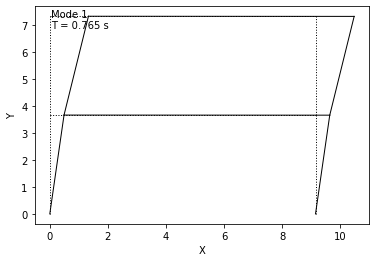

No Model_ODB specified to plot modeshapes
2D model


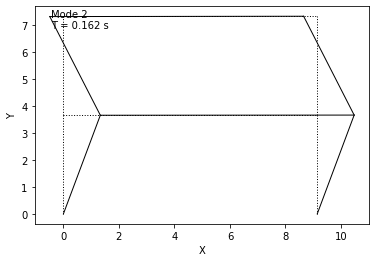

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [9]:
# Display specific mode shape with scale factor of 20 using the active model
# ------------------------------------------------------------------------
opsplt.plot_modeshape(1, 20) # 1st Mode Shape
opsplt.plot_modeshape(2, 20) # 2nd Mode Shape

## <font color=blue>4.3.5. Response Spectrum Analysis (RSA)</font>
As in the case of *Modal Analysis*, in the past version of OpenSees there was no particular function to perform response spectrum analysis. Hence, people were developing their own functions to perform such task. A brand new command to perform this task has been recently added at this [PR](https://github.com/OpenSees/OpenSees/commit/9e1e815430661d51671f07e1b6311a9b91f5e170) to the OpenSees framework. It can be used upon performing *Modal Analysis*.
<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops.responseSpectrum`**](https://opensees.github.io/OpenSeesDocumentation/user/manual/analysis/responseSpectrum.html)</div></font>

In [10]:
def do_rsa(nModes, method = 'CQC', xi = 0.05, aDir = 1):
    """
    Procedure to carry out response spectrum analysis of a model
    Args:
        nModes:       number of modes to be used for analysis
        method:       modal combination method 'CQC' or 'SRSS'
        xi:           damping for CQC modal combination
        aDir:         analysis direction

    Returns:
        eleForces:    Dictionary containing element joint forces
        nodalDisps:   Dictionary containing nodal displacements
    """
    
    # Definition of CQC Combination function
    # ------------------------------------------------------------------------
    def CQC(mu, lambdas, dmp):
        """
        Procedure to carry out Complete Quadratic Combation (CQC) of modes
        Args:
            mu:      analysis results of a node or an element for each mode 
                     (forces, displacements, deformations etc.)
            lambdas: eigenvalues
            dmp:     damping ratio for modes

        Returns:
            u:       combined analysis results of a node or an element
                     (forces, displacements, deformations etc.)
        """   
        u = 0.0
        ne = len(lambdas)
        for i in range(ne):
            for j in range(ne):
                di = dmp[i]
                dj = dmp[j]
                bij = lambdas[i]/lambdas[j]
                rho = ((8.0*((di*dj)**0.5)*(di+bij*dj)*(bij**(3.0/2.0))) /
                    ((1.0-bij**2.0)**2.0 + 4.0*di*dj*bij*(1.0+bij**2.0) + 
                    4.0*(di**2.0 + dj**2.0)*bij**2.0))
                u += mu[i] * mu[j] * rho
        u = (u)**0.5
        return u

    # Definition of SRSS Combination function
    # ------------------------------------------------------------------------
    def SRSS(mu, nModes):
        """
        Procedure to carry out Square-Root-of-Sum-of-Squares (SRSS) combination of modes
        Args:
            mu:      analysis results of a node or an element for each mode 
                     (forces, displacements, deformations etc.)

        Returns:
            u:       combined analysis results of a node or an element
                     (forces, displacements, deformations etc.)
        """   
        u = 0.0
        for i in range(nModes):
            u += mu[i]**2
        return (u)**0.5
    
    # Set analysis parameters for response spectrum analysis
    # ------------------------------------------------------------------------
    # Wipe any previous analysis object
    ops.wipeAnalysis()
    
    # Convergence Test -- determines when convergence has been achieved.
    ops.test('NormUnbalance', 0.0001, 10)
    
    # SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
    ops.algorithm("Linear")
    
    # DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
    ops.numberer('RCM')
    
    # SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
    ops.system('UmfPack')
    
    # Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
    ops.constraints('Transformation')
    
    # Integrator -- determines the predictive step for time t+dt
    ops.integrator('LoadControl', 0.0)
    
    # AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
    ops.analysis('Static')
    
    # Compute the modal properties
    # ------------------------------------------------------------------------
    lambdas = ops.eigen('-genBandArpack', nModes)    # eigenvalue analysis
    ops.modalProperties("-unorm")                    # modal properties
    dmp = [xi]*nModes # currently we use the same damping for each mode (xi)

    # Perform the analysis
    # ------------------------------------------------------------------------
    # Perform a response spectrum analysis mode-by-mode, and grab results during the loop
    
    ModalForces = {} # Initialize the dictionary for modal forces of elements
    for ele in ops.getEleTags():
        ModalForces[ele] = []

    ModalReactions = {} # Initialize the dictionary for modal reaction forces of nodes        
    ModalDisps = {}     # Initialize the dictionary for modal displacement of nodes
    for node in ops.getNodeTags():
        ModalDisps[node] = []
        ModalReactions[node] = []
        
    for i in range(len(lambdas)):
        ops.responseSpectrum(tsTag, aDir, '-mode', i+1)
        for ele in ops.getEleTags():
            forces = np.array(ops.eleResponse(ele, 'force'))
            ModalForces[ele].append(forces)
        for node in ops.getNodeTags():
            disps = np.array(ops.nodeDisp(node))
            ModalDisps[node].append(disps)
            ops.reactions() # Must call this command before using nodeReaction() command.
            reactions = np.array(ops.nodeReaction(node))
            ModalReactions[node].append(reactions)
    
    # Perform modal combination to obtain resultant element forces, nodal displacements and base reactions
    # ------------------------------------------------------------------------
    eleForces = {}
    for ele in ops.getEleTags():
        if method == 'CQC':
            forces = CQC(ModalForces[ele], lambdas, dmp)
        elif method == 'SRSS':
            forces = SRSS(ModalForces[ele], nModes)
        eleForces[ele] = forces
    
    nodalDisps = {}
    nodalReactions = {}
    for node in ops.getNodeTags():
        if method == 'CQC':
            disps = CQC(ModalDisps[node], lambdas, dmp)
            reactions = CQC(ModalReactions[node], lambdas, dmp)
        elif method == 'SRSS':
            disps = SRSS(ModalDisps[node], nModes)
            reactions = SRSS(ModalReactions[node], nModes)
        nodalDisps[node] = disps
        nodalReactions[node] = reactions

    BaseReactions = 0
    for node in nodalReactions.keys():
        forces = nodalReactions[node]
        BaseReactions += forces
        
    return eleForces, nodalDisps, BaseReactions

In [11]:
# Build the numerical model
# ------------------------------------------------------------------------
generate_elastic_model() # generate a clean model

# Define response spectrum to use
# ------------------------------------------------------------------------
SaT = np.loadtxt('Records//SaT.txt') # Response spectrum to use (T,Sa)
Periods = SaT[:,0] # period values
Sa = SaT[:,1]      # spectral accelerations
tsTag = 2          # tag for timeSeries
nModes = 2         # number of modes to combine during RSA
# use the timeSeries as response spectrum function
ops.timeSeries("Path",tsTag,"-time",*Periods,"-values",*Sa,"-factor", g) 
eleForces, nodalDisps, BaseReactions = do_rsa(nModes, 'SRSS') # perform RSA

# Print the results
# ------------------------------------------------------------------------
print('\nElement Forces [kN]:')
for ele in eleForces.keys():
    print('Element ID: ', ele)
    print('i end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][0], eleForces[ele][1], eleForces[ele][2]))
    print('j end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][3], eleForces[ele][4], eleForces[ele][5]))

print('\nNodal Displacements [m]:')
for node in nodalDisps.keys():
    print('Node ID: ', node)
    print('d1= %.5f, d2= %.5f, d3= %.5f'% (nodalDisps[node][0],nodalDisps[node][1], nodalDisps[node][2])) 
    
print('\nTotal Base Reactions [kN]:')
print('F1= %.3f, F2= %.3f, F3= %.3f' % (BaseReactions[0], BaseReactions[1], BaseReactions[2]))


Element Forces [kN]:
Element ID:  11
i end: F1= 1637.238, F2= 850.647, F3= 6077.297
j end: F1= 1637.238, F2= 850.647, F3= 939.022
Element ID:  12
i end: F1= 1637.238, F2= 850.647, F3= 6077.297
j end: F1= 1637.238, F2= 850.647, F3= 939.022
Element ID:  13
i end: F1= 0.000, F2= 415.311, F3= 1898.803
j end: F1= 0.000, F2= 415.311, F3= 1898.803
Element ID:  21
i end: F1= 1176.083, F2= 435.021, F3= 2367.781
j end: F1= 1176.083, F2= 435.021, F3= 1976.443
Element ID:  22
i end: F1= 1176.083, F2= 435.021, F3= 2367.781
j end: F1= 1176.083, F2= 435.021, F3= 1976.443
Element ID:  23
i end: F1= 0.000, F2= 432.293, F3= 1976.443
j end: F1= 0.000, F2= 432.293, F3= 1976.443

Nodal Displacements [m]:
Node ID:  1
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  2
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  3
d1= 0.06275, d2= 0.00023, d3= 0.02575
Node ID:  4
d1= 0.06275, d2= 0.00023, d3= 0.02575
Node ID:  5
d1= 0.16974, d2= 0.00035, d3= 0.02683
Node ID:  6
d1= 0.16974, d2= 0.00035, d3= 0.02683

Total

Using ResponseSpectrumAnalysis - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


## <font color=blue>4.4. Nonlinear Inelastic Frame Example</font>
### <font color=blue>4.4.1. Definition of Fiber Sections</font>
We are going to construct a numerical model for the frame example accounting for material inelasticty and geometric nonlinearities. Inelasticity is going to be introducing by using [Fiber](https://openseespydoc.readthedocs.io/en/latest/src/section.html) sections with inelastic properties. To make our job easier a procedure to define the similar sections can be constructed. Further, *ops_vis.plot_fiber_section* module can be used to visualize the fibir sections.

<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops.section`**](https://openseespydoc.readthedocs.io/en/latest/src/section.html)
[**`ops.patch`**](https://openseespydoc.readthedocs.io/en/latest/src/patch.html)
[**`ops.layer`**](https://openseespydoc.readthedocs.io/en/latest/src/layer.html)  
[**`ops_vis.plot_fiber_section`**](https://openseespydoc.readthedocs.io/en/latest/src/ops_vis_plot_fiber_section.html)  
</div></font>

In [12]:
def BuildRCrectSection (SecID, HSec, BSec, coverH, coverB, coreID, coverID, steelID, 
                        numBarsTop, barAreaTop, numBarsBot, barAreaBot, numBarsIntTot, barAreaInt, 
                        nfCoreY=20, nfCoreZ=20, nfCoverY=20, nfCoverZ=20, pflag=0):
    """
     Build fiber rectangular RC section, 1 steel layer top, 1 bot, 1 skin, confined core
     Define a procedure which generates a rectangular reinforced concrete section
     with one layer of steel at the top & bottom, skin reinforcement and a 
     confined core.
            by: Volkan Ozsarac, 2021
                adapted from Silvia Mazzoni, 2006
     
     Formal arguments
        SecID:         tag for the section that is generated by this procedure
        HSec:          depth of section, along local-y axis
        BSec:          width of section, along local-z axis
        cH:            distance from section boundary to neutral axis of reinforcement
        cB:            distance from section boundary to side of reinforcement
        coreID:        material tag for the core patch
        coverID:       material tag for the cover patches
        steelID:       material tag for the reinforcing steel
        numBarsTop:    number of reinforcing bars in the top layer
        numBarsBot:    number of reinforcing bars in the bottom layer
        numBarsIntTot: TOTAL number of reinforcing bars on the intermediate layers, symmetric about z axis and 2 bars per layer-- needs to be an even integer
        barAreaTop:    cross-sectional area of each reinforcing bar in top layer
        barAreaBot:    cross-sectional area of each reinforcing bar in bottom layer
        barAreaInt:    cross-sectional area of each reinforcing bar in intermediate layer 
        nfCoreY:       number of fibers in the core patch in the y direction
        nfCoreZ:       number of fibers in the core patch in the z direction
        nfCoverY:      number of fibers in the cover patches with long sides in the y direction
        nfCoverZ:      number of fibers in the cover patches with long sides in the z direction
        pflag:         optional flag to plot fiber sections
        
                            y
                            ^
                            |     
                 ----------------------- --        |
                 |   o      o      o   | -- coverH |
                 |                     |           |
                 |   o             o   |           |
          z <--- |          +          |       HSec|
                 |   o             o   |           |
                 |                     |           |
                 |   o o o o o o o o   | --coverH  |
                 ----------------------- --        |
                 |--------Bsec---------|
                 |---|   coverB   |----|
    
                           y
                           ^
                           |    
                 ----------------------
                 |\      cover       /|
                 | \------Top-------/ |
                 |c|                |c|
                 |o|                |o|
         z <-----|v|      core      |v|  HSec
                 |e|                |e|
                 |r|                |r|
                 | /-------Bot------\ |
                 |/       cover      \|
                 ----------------------
                           Bsec
        
    
     Notes
        The core concrete ends at the NA of the reinforcement
        The center of the section is at (0,0) in the local axis system
    """
    # Define some parameters
    # ------------------------------------------------------------------------
    coverY = HSec/2.0                 # The distance from the section z-axis to the edge of the cover concrete -- outer edge of cover concrete
    coverZ = BSec/2.0                 # The distance from the section y-axis to the edge of the cover concrete -- outer edge of cover concrete
    coreY = coverY-coverH             # The distance from the section z-axis to the edge of the core concrete --  edge of the core concrete/inner edge of cover concrete
    coreZ = coverZ-coverB             # The distance from the section y-axis to the edge of the core concrete --  edge of the core concrete/inner edge of cover concrete
    numBarsInt = int(numBarsIntTot/2) # number of intermediate bars per side
    IntYStart = -coreY + 2*coreY/(numBarsInt+1) # Bottom (y-axis) coordinate for intermediate bars (assuming that they are uniformly distributed)
    IntYEnd = coreY - 2*coreY/(numBarsInt+1)    # Top (y-axix) coordinate for for intermediate bars (assuming that they are uniformly distributed)
    
    # Define the fiber section
    # ------------------------------------------------------------------------
    ops.section('Fiber', SecID)
    # Define the core patch
    ops.patch('quad', coreID, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ)

    # Define the four cover patches
    ops.patch('quad', coverID, 2, nfCoverY, -coverY, coverZ, -coreY,   coreZ,   coreY,   coreZ,  coverY, coverZ)
    ops.patch('quad', coverID, 2, nfCoverY, -coreY, -coreZ,  -coverY, -coverZ,  coverY, -coverZ, coreY,  -coreZ)
    ops.patch('quad', coverID, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY,  -coreZ, -coreY,   coreZ)
    ops.patch('quad', coverID, nfCoverZ, 2,  coreY,  coreZ,   coreY,  -coreZ,   coverY, -coverZ, coverY, coverZ)    

    # Define reinforcing layers
    ops.layer('straight', steelID, numBarsInt ,barAreaInt, IntYStart,  coreZ,  IntYEnd,  coreZ) # intermediate skin reinf. +z
    ops.layer('straight', steelID, numBarsInt ,barAreaInt, IntYStart,  -coreZ,  IntYEnd,  -coreZ) # intermediate skin reinf. -z
    ops.layer('straight', steelID, numBarsTop ,barAreaTop,  coreY,  coreZ,  coreY, -coreZ) # top layer reinfocement
    ops.layer('straight', steelID, numBarsBot ,barAreaBot, -coreY,  coreZ, -coreY, -coreZ) # bottom layer reinforcement
    
    # Plot the fiber section data
    # ------------------------------------------------------------------------
    if pflag != 0:
        fiber_sec = [['section', 'Fiber', SecID],
                     ['patch', 'quad', coreID, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY, -coreZ, coreY, -coreZ, coreY, coreZ],
                     ['patch', 'quad', coverID, 2, nfCoverY, -coverY, coverZ, -coreY,   coreZ,   coreY,   coreZ,  coverY, coverZ],
                     ['patch', 'quad', coverID, 2, nfCoverY, -coreY, -coreZ,  -coverY, -coverZ,  coverY, -coverZ, coreY,  -coreZ],
                     ['patch', 'quad', coverID, nfCoverZ, 2, -coverY, coverZ, -coverY, -coverZ, -coreY,  -coreZ, -coreY,   coreZ],
                     ['patch', 'quad', coverID, nfCoverZ, 2,  coreY,  coreZ,   coreY,  -coreZ,   coverY, -coverZ, coverY, coverZ],
                     ['layer', 'straight', steelID ,numBarsInt ,barAreaInt, IntYStart,  coreZ,  IntYEnd,  coreZ],
                     ['layer', 'straight', steelID ,numBarsInt ,barAreaInt, IntYStart,  -coreZ,  IntYEnd,  -coreZ],
                     ['layer', 'straight', steelID ,numBarsTop ,barAreaTop,  coreY,  coreZ,  coreY, -coreZ],
                     ['layer', 'straight', steelID ,numBarsBot ,barAreaBot, -coreY,  coreZ, -coreY, -coreZ]
                    ]

        matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
        opsv.plot_fiber_section(fiber_sec, matcolor=matcolor)
        plt.title('Section ID:%d' %SecID)
        plt.axis('equal')
        plt.savefig('fiber_sec_'+str(SecID)+'.png')
        plt.show()

### <font color=blue>4.4.2. Definition of the Numerical Model</font>
For all the frame elements [Force-Based Beam-Column Element](https://openseespydoc.readthedocs.io/en/latest/src/ForceBeamColumn.html) formulation is used. 
In the case of beam elements, [HingeRadau](https://openseespydoc.readthedocs.io/en/latest/src/HingeRadau.html) integration scheme is adopted. Interior sections are [elastic](https://openseespydoc.readthedocs.io/en/latest/src/elasticSection.html) whereas sections located at the beam ends are [Fiber](https://openseespydoc.readthedocs.io/en/latest/src/section.html) sections. In such an approach, the plasticity is concentrated at the beam ends with pre-defined plastic hinge length (*lumped plasticity*). In the earlier versions of OpenSees, this type of element was called [Beam With Hinges Element](https://openseespydoc.readthedocs.io/en/latest/src/beamWithHinges.html).
In the case of column elements, [Lobatto](https://openseespydoc.readthedocs.io/en/latest/src/Lobatto.html) integration scheme is adopted. In particular, 5 integration points along the element is used. At these integration points the same *Fiber* section is considered. In this approach, no plastic hinge length is defined, and the plasticity is distributed (*distributed plasticity*) along the element.

<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops.beamIntegration`**](https://openseespydoc.readthedocs.io/en/latest/src/beamIntegration.html)  
[**`ops.uniaxialMaterial`**](https://openseespydoc.readthedocs.io/en/latest/src/uniaxialMaterial.html)  
</div></font>

In [13]:
def generate_inelastic_model(pflag = 0):
    """
    Procedure to define the elastic numerical model of 2D frame example
    Args:
        pflag: optional flag to plot fiber sections
    Returns:
        None
    """
    # Parameters for overall model geometry
    # ------------------------------------------------------------------------
    LBeam = 360.0*inch 
    LCol = 144.0*inch 
    
    # Section properties
    # ------------------------------------------------------------------------
    kv = 5/6                          # Shape factor for rectangular sections
    kBeam = 0.5                       # Flexural stiffness modification factor for beams
    kCol = 0.8                        # Flexural stiffness modification factor for columns
    HCol = 28*inch                    # Column depth -- perpendicular to bending axis
    BCol = HCol                       # Column width -- parallel to bending axis
    HBeam = 24*inch                   # Beam depth -- perpendicular to bending axis
    BBeam = 18*inch                   # Beam width -- parallel to bending axis
    cover = 2.5*inch  # rectangular-RC-Column cover
    # Elastic section properties
    Acol = HCol*BCol                  # Cross-sectional area of columns
    Icol = kCol*1/12*BCol*HCol**3     # Effective moment of inertia of columns
    Avcol = kv*Acol                   # Shear area for beams (Timoshenko Elements)
    Abeam = BBeam*HBeam               # Cross-sectional area of beams
    Ibeam = kBeam*1/12*BBeam*HBeam**3 # Gross moment of inertia of beams
    Avbeam = kv*Abeam                 # Shear area for beams (Timoshenko Elements)
    # Reinforcing steel bar arrangement for columns
    numBarsTopCol = 8                 # number of longitudinal-reinforcement bars on top layer
    numBarsBotCol = 8                 # number of longitudinal-reinforcement bars on bottom layer
    numBarsIntCol = 6                 # TOTAL number of reinforcing bars on the intermediate layers
    barAreaTopCol = 1*inch**2         # longitudinal-reinforcement bar area
    barAreaBotCol = 1*inch**2         # longitudinal-reinforcement bar area
    barAreaIntCol = 1*inch**2         # longitudinal-reinforcement bar area
    # Reinforcing steel bar arrangement for beams
    numBarsTopBeam = 6                # number of longitudinal-reinforcement bars on top layer
    numBarsBotBeam = 6                # number of longitudinal-reinforcement bars on bottom layer
    numBarsIntBeam = 2                # TOTAL number of reinforcing bars on the intermediate layers
    barAreaTopBeam = 1*inch**2        # longitudinal-reinforcement bar area
    barAreaBotBeam = 1*inch**2        # longitudinal-reinforcement bar area
    barAreaIntBeam = 1*inch**2        # longitudinal-reinforcement bar area
    
    # Material Properties
    # ------------------------------------------------------------------------
    # CONCRETE
    fc = 4.0*ksi                    # Nominal concrete compressive strength
    Ec = 5000*MPa*(fc/MPa)**0.5     # Young's modulus
    nu = 0.2                        # Poisson's ratio
    Gc = Ec/(2*(1+nu))              # Shear modulus
    # unconfined concrete
    Kres = 0.2          # ratio of residual/ultimate to maximum stress
    fc1U = -fc          # UNCONFINED concrete (todeschini parabolic model), maximum stress
    eps1U = -0.003      # strain at maximum strength of unconfined concrete
    fc2U = Kres*fc1U    # ultimate stress
    eps2U = -0.01       # strain at ultimate stress
    # confined concrete
    Kfc = 1.2           # ratio of confined to unconfined concrete strength
    fc1C = Kfc*fc1U     # CONFINED concrete (mander model), maximum stress
    eps1C = 2*fc1C/Ec   # strain at maximum stres
    fc2C = Kres*fc1C    # ultimate stress
    eps2C = 5*eps1C     # strain at ultimate stress 
    # tensile-strength properties
    Lambda = 0.1        # ratio between unloading slope at eps2 and initial slope Ec
    fct = 0.14*fc       # tensile strength +tension
    Ets = fct/0.002     # tension softening stiffness
    # REINFORCING STEEL
    fsy = 66.8*ksi;     # Yield stress
    Es = 29000*ksi;     # Young's modulus
    bs = 0.01           # strain-hardening ratio
    R0 = 18             # control the transition from elastic to plastic branches
    cR1 = 0.925         # control the transition from elastic to plastic branches
    cR2 = 0.15          # control the transition from elastic to plastic branches
    minStrain = -0.1    # minimum steel strain in the fibers (steel buckling)
    maxStrain = 0.1     # maximum steel strain in the fibers (steel rupture)
    
    # Structural Loads
    # ------------------------------------------------------------------------
    PCol = 0.05*fc*HCol*BCol  # Point loads on beam column joints
    wBeam = 0.04*fc*HCol*BCol/LBeam # Distributed loads on beams
    
    # clear memory of past model definitions
    # ------------------------------------------------------------------------
    ops.wipe('all')                                    
    
    # Create ModelBuilder (with two-dimensions and 3 DOF/node)
    # ------------------------------------------------------------------------
    ops.model('basic', '-ndm', 2, '-ndf', 3)

    # Create nodes
    # ------------------------------------------------------------------------
    ops.node(1, 0.0, 0.0)
    ops.node(2, LBeam, 0.0)
    ops.node(3, 0.0, LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(4, LBeam, LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(5, 0.0, 2*LCol, '-mass', PCol/g, PCol/g, 0.0)
    ops.node(6, LBeam, 2*LCol, '-mass', PCol/g, PCol/g, 0.0)
    
    # Alternatively, you can define nodal masses as follows
    # ------------------------------------------------------------------------
    # ops.mass(3, PCol/g, PCol/g, 0.0)
    # ops.mass(4, PCol/g, PCol/g, 0.0)
    # ops.mass(5, PCol/g, PCol/g, 0.0)
    # ops.mass(6, PCol/g, PCol/g, 0.0)
    
    # Single-point constraints at base of columns
    # ------------------------------------------------------------------------
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 1, 1, 1)

    # Geometric transformations
    # ------------------------------------------------------------------------
    ColTransfTag = 1
    BeamTransfTag = 2
    ops.geomTransf('PDelta', ColTransfTag)  # includes P-Delta effects
    ops.geomTransf('Linear', BeamTransfTag) # does not include P-Delta effects

    # Define materials for nonlinear columns
    # ------------------------------------------------------------------------
    IDconcCover = 1 # Tag for unconfined concrete material
    IDconcCore = 2 # Tag for confined concrete material
    IDSteel = 3 # Tag for steel material without min-max properties
    IDMinMaxSteel = 4 # Tag for steel material with min-max properties
    IDshearCol = 5 # Shear material tag for columns
    ops.uniaxialMaterial('Concrete02', IDconcCover, fc1U, eps1U, fc2U, eps2U, Lambda, fct, Ets)
    ops.uniaxialMaterial('Concrete02', IDconcCore,  fc1C, eps1C, fc2C, eps2C, Lambda, fct, Ets)
    ops.uniaxialMaterial('Steel02', IDSteel, fsy, Es, bs,  R0, cR1, cR2)
    ops.uniaxialMaterial('MinMax', IDMinMaxSteel, IDSteel, '-min', minStrain, '-max', maxStrain)
    ops.uniaxialMaterial('Elastic', IDshearCol, Gc*Avcol) 
    
    # Define sections
    # ------------------------------------------------------------------------
    # rectangular fiber section with one layer of steel evenly distributed around the perimeter and a confined core.
    ColSecTag_Fiber = 1 # Tag for fiber column sections
    ColSecTag = 2       # Tag for fiber column section aggregated with elastic shear section
    BeamSecTag = 3      # Tag for fiber beam section which is located at the beam ends
    ElBeamSec = 4       # Tag for elastic sbeam section which is located at the beam interior
    BuildRCrectSection(ColSecTag_Fiber, HCol, BCol, cover, cover, IDconcCore, IDconcCover, IDMinMaxSteel, 
                       numBarsTopCol, barAreaTopCol, numBarsBotCol, barAreaBotCol, numBarsIntCol, barAreaIntCol,
                       pflag = pflag) 
    BuildRCrectSection(BeamSecTag, HBeam, BBeam, cover, cover, IDconcCore, IDconcCover, IDMinMaxSteel, 
                       numBarsTopBeam, barAreaTopBeam, numBarsBotBeam, barAreaBotBeam, numBarsIntBeam, 
                       barAreaIntBeam, pflag = pflag)
    ops.section('Aggregator', ColSecTag, IDshearCol, 'Vy', '-section', ColSecTag_Fiber)
    ops.section('Elastic', ElBeamSec, Ec, Abeam, Ibeam, Gc, kv)

    # Define integration schemes for frame elements
    # ------------------------------------------------------------------------
    # Lobatto for column elements, HingeRadau for beam elements
    ColIntTag = 1     # Integration tag for columns
    BeamIntTag = 2    # Integration tag for beams
    np = 5            # Number of integration points along length of column elements
    Lpl = 0.5 * HBeam # Plastic hinge length of beam elements, alternatively, see formula by Priestley et al. 2007
    ops.beamIntegration('Lobatto', ColIntTag, ColSecTag, np) 
    ops.beamIntegration('HingeRadau', BeamIntTag, BeamSecTag, Lpl, BeamSecTag, Lpl, ElBeamSec) # HingeRadau integration scheme
    
    # Define elements
    # ------------------------------------------------------------------------
    # forceBeamColumn element formulation is being used
    ops.element('forceBeamColumn', 11, 1, 3, ColTransfTag, ColIntTag)
    ops.element('forceBeamColumn', 12, 2, 4, ColTransfTag, ColIntTag)
    ops.element('forceBeamColumn', 21, 3, 5, ColTransfTag, ColIntTag)
    ops.element('forceBeamColumn', 22, 4, 6, ColTransfTag, ColIntTag)
    ops.element('forceBeamColumn', 13, 3, 4, BeamTransfTag, BeamIntTag,'-mass', wBeam/g)
    ops.element('forceBeamColumn', 23, 5, 6, BeamTransfTag, BeamIntTag,'-mass', wBeam/g)

    # Create a Plain load pattern with a Linear TimeSeries
    # ------------------------------------------------------------------------
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)

    # Create nodal loads at nodes
    # ------------------------------------------------------------------------
    ops.load(3, 0.0, -PCol, 0.0)
    ops.load(4, 0.0, -PCol, 0.0)
    ops.load(5, 0.0, -PCol, 0.0)
    ops.load(6, 0.0, -PCol, 0.0) 
    
    # Apply distributed loading along the beam
    # ------------------------------------------------------------------------
    ops.eleLoad('-ele', 13, '-type', '-beamUniform', -wBeam, 0)
    ops.eleLoad('-ele', 23, '-type', '-beamUniform', -wBeam, 0)

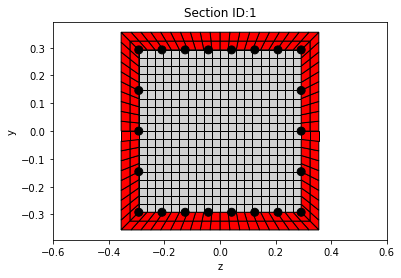

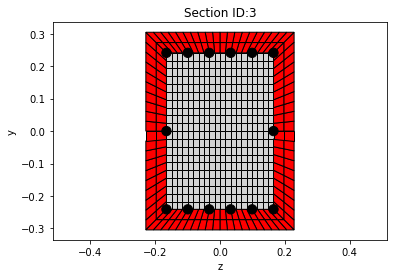

In [14]:
# Build the numerical model
# ------------------------------------------------------------------------
generate_inelastic_model(pflag = 1)

No Model_ODB specified, trying to get data from the active model.
2D model


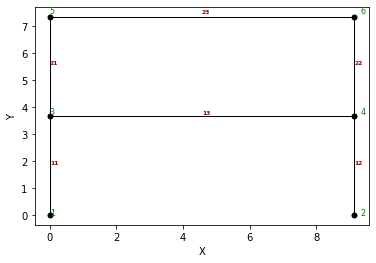

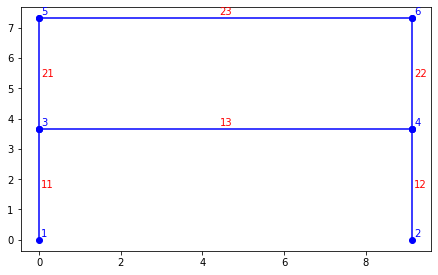

In [15]:
# Display the model with tag lebels
# ------------------------------------------------------------------------
opsplt.plot_model('nodes','elements') # Using Get_Rendering package
opsv.plot_model()                     # Using ops_vis package

In [16]:
# Perform static analysis under gravity loads
# ------------------------------------------------------------------------
eleForces, nodalDisps, BaseReactions = do_gravity()

# Print the results
# ------------------------------------------------------------------------
print('\nElement Forces [kN]:')
for ele in eleForces.keys():
    print('Element ID: ', ele)
    print('i end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][0], eleForces[ele][1], eleForces[ele][2]))
    print('j end: F1= %.3f, F2= %.3f, F3= %.3f' %  (eleForces[ele][3], eleForces[ele][4], eleForces[ele][5]))

print('\nNodal Displacements [m]:')
for node in nodalDisps.keys():
    print('Node ID: ', node)
    print('d1= %.5f, d2= %.5f, d3= %.5f'% (nodalDisps[node][0],nodalDisps[node][1], nodalDisps[node][2])) 
    
print('\nTotal Base Reactions [kN]:')
print('F1= %.3f, F2= %.3f, F3= %.3f' % (BaseReactions[0], BaseReactions[1], BaseReactions[2]))


Element Forces [kN]:
Element ID:  11
i end: F1= 68.658, F2= 1952.947, F3= -89.832
j end: F1= -68.658, F2= -1952.947, F3= -161.523
Element ID:  12
i end: F1= -68.658, F2= 1952.947, F3= 89.832
j end: F1= 68.658, F2= -1952.947, F3= 161.523
Element ID:  13
i end: F1= -119.809, F2= 278.992, F3= 429.801
j end: F1= 119.809, F2= 278.992, F3= -429.801
Element ID:  21
i end: F1= 188.468, F2= 976.474, F3= -268.278
j end: F1= -188.468, F2= -976.474, F3= -420.858
Element ID:  22
i end: F1= -188.468, F2= 976.474, F3= 268.278
j end: F1= 188.468, F2= -976.474, F3= 420.858
Element ID:  23
i end: F1= 188.468, F2= 278.992, F3= 420.858
j end: F1= -188.468, F2= 278.992, F3= -420.858

Nodal Displacements [m]:
Node ID:  1
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  2
d1= 0.00000, d2= 0.00000, d3= 0.00000
Node ID:  3
d1= -0.00012, d2= -0.00049, d3= -0.00021
Node ID:  4
d1= 0.00012, d2= -0.00049, d3= 0.00021
Node ID:  5
d1= 0.00009, d2= -0.00074, d3= -0.00064
Node ID:  6
d1= -0.00009, d2= -0.00074, d3= 0.

In [17]:
# Perform the modal analysis
# ------------------------------------------------------------------------
lambdas = ops.eigen('-genBandArpack', 2)                            # eigenvalue analysis (for 2 modes)
ops.modalProperties("-print", "-file", "ModalReport.txt", "-unorm") # perform modal analysis, and print results

# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 2 for 2D problems, 3 for 3D problems.
2


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       80.2623       8.95892       1.42586      0.701333
              2       2005.04       44.7776       7.12658       0.14032


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY           RMZ
# ------------- ------------- -------------
        398.154       398.154       9654.33


* 4. TOTAL FREE MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including only the masses at free DOFs.
#            MX            MY           RMZ
# ------------- ------------- -------------
        398.154       398.154       9654.33




No Model_ODB specified to plot modeshapes
2D model


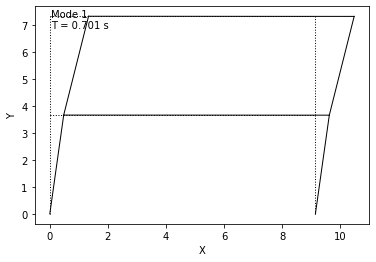

No Model_ODB specified to plot modeshapes
2D model


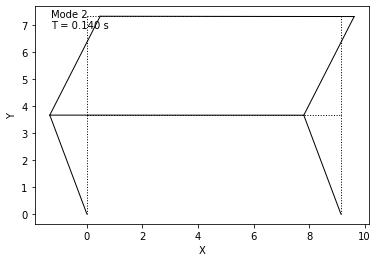

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [18]:
# Display specific mode shape with scale factor of 20 using the active model
# ------------------------------------------------------------------------
opsplt.plot_modeshape(1, 20) # 1st Mode  Shape
opsplt.plot_modeshape(2, 20) # 2nd Mode  Shape

## <font color=blue>4.2.1. Nonlinear Static Pushover Analysis (NSPA)</font>
As it is seen before creating such procedures is very handy. In a similar way, a function to perform displacement controlled nonlinear static pushover analysis (NSPA) can be defined. Upon completing the gravity analysis, the incremental loads are applied. Then call the function can be called.

In [19]:
def do_nspa(dmax, ctrlNode, ctrlDOF, nSteps):
    """
    Procedure to carry out a non-cylic pushover of a model
    Args:
        dmax:         Maximum displacement to run analysis
        ctrlNode:     Node to control with the displacement integrator
        ctrlDOF:      DOF the loading is applied
        nSteps:       Number of steps

    Returns:
        LoadFactor:   List containing load factors used throughout the analysis
        DispCtrlNode: List containing displacement of control node throughout the analysis  

    """
    # Set analysis parameters
    # ------------------------------------------------------------------------
    # Wipe any previous analysis object
    ops.wipeAnalysis()
    
    # Convergence Test -- determines when convergence has been achieved.
    tol = 1.0e-8  # Set the tolerance (default)
    iterMax = 50  # Set the max bumber of iterations (default)
    pFlag = 0     # Optional print flag (default is 0). Valid options: 0-5
    nType = 2     # optional type of norm (default is 2). Valid options: 0-2
    ops.test('NormDispIncr', tol, iterMax, pFlag, nType)
    
    # SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
    ops.algorithm('Newton', '-initial')
    
    # DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
    ops.numberer('RCM')
    
    # SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
    ops.system('BandGeneral')
    
    # Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
    ops.constraints('Transformation')
    
    # Integrator -- determines the predictive step for time t+dt
    dU = dmax/nSteps # Displacement increment 
    ops.integrator('DisplacementControl', ctrlNode, ctrlDOF, dU)
    
    # AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
    ops.analysis('Static')

    # Initialize some parameters
    # ------------------------------------------------------------------------
    ok = 0.0           # analysis result
    step = 1           # current step number
    loadf = 1.0        # This feature of disabling the possibility of having a negative loading has been included
    LoadFactor = [0]   # List containing load factors used throughout the analysis
    DispCtrlNode = [0] # List containing displacement of control node throughout the analysis  
    
    # Perform the analysis
    # ------------------------------------------------------------------------
    while step <= nSteps and ok == 0 and loadf > 0:
        step += 1           # Update the current step number
        ok = ops.analyze(1) # Run a step of the analysis
        
        if ok != 0: # If the analysis fails, we can change the strategy to achieve convergence
            print("~~~ Analysis did not converge at step: %d/%d, trying KrylovNewton ..." % (step,nSteps))
            ops.algorithm('KrylovNewton')
            ok = ops.analyze(1)
            if ok == 0: # If the analysis works, we can go back to previous strategy
                print("~~~ That worked, back to regular Newton ...")
                ops.algorithm('Newton', '-initial')

        if ok == 0: # If the analysis successful save some stuff
            loadf = ops.getTime()                                # get load factor
            LoadFactor.append(ops.getTime())                     # append loadfactor
            DispCtrlNode.append(ops.nodeDisp(ctrlNode, ctrlDOF)) # append displacement
            
    # Print the final status of the analysis
    # ------------------------------------------------------------------------
    if ok != 0:
        Analysis =  "Displacement Control Analysis is FAILED to converge at step: %d/%d" % (step,nSteps)
    else:
        Analysis = "Displacement Control Analysis is SUCCESSFUL"
    if loadf <= 0:
        Analysis = "Stopped because of Load factor below zero: %.f" % loadf
    print('------------------------------------------------------------------------')
    print(Analysis)
        
    return LoadFactor, DispCtrlNode     

after: 50 iterations  current Norm: 2.1087e-07 (max: 1e-08, Norm deltaR: 0.518744)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 711.607
OpenSees > analyze failed, returned: -3 error flag


~~~ Analysis did not converge at step: 1480/2000, trying KrylovNewton ...
~~~ That worked, back to regular Newton ...
------------------------------------------------------------------------
Displacement Control Analysis is SUCCESSFUL


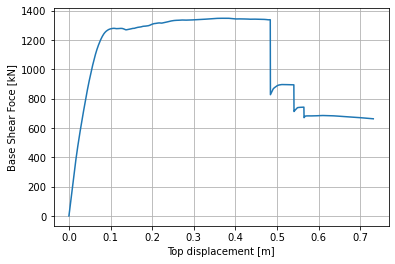

In [20]:
# Build the numerical model
# ------------------------------------------------------------------------
generate_inelastic_model()

# Perform static analysis under gravity loads
# ------------------------------------------------------------------------
eleForces, nodalDisps, BaseReactions = do_gravity()

# Apply loads
# ------------------------------------------------------------------------
# Triangular force distribution, (set sum = 1 so that loadfactor = Total Base Shear)
ops.timeSeries('Linear', 2)  # Define the timeSeries for the load pattern
ops.pattern('Plain', 2, 2)   # Define load pattern -- generalized
ops.load(3, 0.33,0,0)        # Apply the incremental load on node 3
ops.load(5, 0.67,0,0)        # Apply the incremental load on node 5

# Perform Nonlinear Static Pushover Analysis (NSPA)
# ------------------------------------------------------------------------
Hbuilding = 2*144.0*inch # Building height
dmax = 0.1*Hbuilding     # Maximum displacement to run the analysis
ctrlNode=5               # Control node
ctrlDOF=1                # Control dof
nSteps=2000              # Number of steps to run the analysis
LoadFactor, DispCtrlNode = do_nspa(dmax, ctrlNode, ctrlDOF, nSteps) # Perform NSPA

# Plot the capacity curve
# ------------------------------------------------------------------------
plt.figure()
plt.plot(DispCtrlNode,LoadFactor)
plt.xlabel('Top displacement [m]')
plt.ylabel('Base Shear Foce [kN]')
plt.grid(True)

## <font color=blue>4.2.2. Nonlinear Response History Analysis (NRHA)</font>

Simiarly, a procedure to carry nonlinear response history analysis (NRHA) can be defined. Upon completing gravity analysis, and defining the excitation, this function can be called. Note that the current inelastic frame model did not have damping definition. Hence, before performing NRHA, define damping for the structure structure is set. In particular, the damping is proportional to the last committed stiffness and mass matrices. Since siffness matrix changes at each analysis step, this means that the damping matrix is going to be re-calculated. The rayleigh damping coefficients are obtained based on the first two modes. 

<font color=red><div style="text-align: right"> **Documentation for**  
[**`ops.rayleigh`**](https://openseespydoc.readthedocs.io/en/latest/src/reyleigh.html#)  
</div></font>

In [21]:
def do_nrha(tNode, bNode, Dt, Tmax, Dc):
    """
    Function to perform Nonlinear Response History Analysis
    Args:
        tNode:    top nodes for the drift calculation
        bNode:    bottom nodes for the drift calculation
        Dt:       Analysis time step
        Tmax:     Length of the record (including padding of 0's)
        Dc:       Drift capacity for pier drift (%)

    Returns:
        mdrft:    Peak Interstorey Drifts [%]
        
    Note:
        About Newmark Integrator;
        gamma = 1/2, beta = 1/4 --> Average Acceleration Method; Unconditionally stable
        gamma = 1/2, beta = 1/6 --> Linear Acceleration Method; Conditionally stable: Dt / T > 0.551   
    """
    # Set analysis settings
    # ------------------------------------------------------------------------
    # Wipe any previous analysis object
    ops.wipeAnalysis()
    
    # Convergence Test -- determines when convergence has been achieved.
    tol = 1.0e-8  # Set the tolerance (default)
    iterMax = 50  # Set the max bumber of iterations (default)
    pFlag = 0     # Optional print flag (default is 0). Valid options: 0-5
    nType = 2     # optional type of norm (default is 2). Valid options: 0-2
    ops.test('NormDispIncr', tol, iterMax, pFlag, nType)
    
    # SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
    ops.algorithm('Newton', '-initial')
    
    # DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
    ops.numberer('RCM')
    
    # SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
    ops.system('BandGeneral')
    
    # Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
    ops.constraints('Transformation')
    
    # Integrator -- determines the predictive step for time t+dt
    gamma = 0.5   # Set Newmark gamma coefficient
    beta = 0.25   # Set Newmark beta coefficient
    ops.integrator('Newmark', gamma, beta)
    
    # AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
    ops.analysis('Transient')
    
    # Initialize some parameters
    # ------------------------------------------------------------------------
    cIndex = 0         # Initially define the control index (-1 for non-converged, 0 for stable, 1 for global collapse)
    controlTime = 0.0  # Start the controlTime
    ok = 0             # Set the convergence to 0 (initially converged)
    mflr = 0           # Set the initial pier collapse location
    h = []             # storey heights
    mdrft = []         # the interstorey drift values
    for i in range(len(tNode)):
        # Find the coordinates of the nodes in Global Y (2)
        top2 = ops.nodeCoord(tNode[i], 2)
        bot2 = ops.nodeCoord(bNode[i], 2)
        dist = top2 - bot2
        h.append(dist)     # Current pier height
        mdrft.append(0.0)  # We will populate the lists with zeros initially
        if dist == 0: print("WARNING: Zerolength found in drift check")
            
    # Perform the analysis
    # ------------------------------------------------------------------------
    while cIndex == 0 and controlTime <= Tmax and ok == 0:
        ok = ops.analyze(1, Dt)      # Run a step of the analysis
        controlTime = ops.getTime()  # Update the control time

        # If the analysis fails, we can change some stuff to achieve convergence
        if ok != 0:
            print("~~~ Analysis did not converge at %.2f, trying KrylovNewton ..." % controlTime)
            ops.algorithm('KrylovNewton')
            ok = ops.analyze(1)
            if ok == 0:
                print("~~~ That worked .. back to regular Newton")
                ops.algorithm('Newton', '-initial')
            else: # Bye bye...  Failed to converge, exit the analysis.
                cIndex = -1
                
        # If the analysis is successful some results can be stored, 
        if ok == 0:        
            # Let's get the peak interstorey drift ratios at each floor (mdrft).
            for i in range(len(tNode)):
                tNode_disp = ops.nodeDisp(tNode[i], 1)              # Current top node disp in dof 1
                bNode_disp = ops.nodeDisp(bNode[i], 1)              # Current bottom node disp in dof 1
                cHt = h[i]                                          # Current interstorey height
                cdrft = 100.0 * abs(tNode_disp - bNode_disp) / cHt  # Current interstorey drift in dof 1 [%]
                if cdrft >= mdrft[i]: mdrft[i] = cdrft              # Update the interstorey drift in dof 1 [%]
            
            # Stop the analysis if the interstorey drift limit is exceeded 
            if any(i >= Dc for i in mdrft): 
                cIndex = 1 # Set the state of the model to local collapse (=1)

    # Print the final status of the analysis
    # ------------------------------------------------------------------------
    if cIndex == -1:
        Analysis = "Analysis is FAILED to converge at %.3f of %.3f" % (controlTime, Tmax)
    if cIndex == 0:
        text = ["\nInterstorey drift: %.2f%% at floor %d" % (mdrft[i],i+1) for i in range(len(mdrft))]
        Analysis = ''.join(['Analysis is SUCCESSFULLY completed']+text)
    if cIndex == 1:
        Analysis = "Analysis is STOPPED, peak interstorey drift ratio, %d%%, is exceeded, global COLLAPSE is observed" % Dc
    print('------------------------------------------------------------------------')
    print(Analysis)
    
    return mdrft

In [22]:
# Build the numerical model
# ------------------------------------------------------------------------
generate_inelastic_model()

# Perform static analysis under gravity loads
# ------------------------------------------------------------------------
eleForces, nodalDisps, BaseReactions = do_gravity()

# Set damping 
# ------------------------------------------------------------------------
# Using mass and committed stiffness proportional damping 
# rayleigh coefficients are calculated based on first two modes 
xi = 0.05                               # Damping ratio
Lambda = ops.eigen('-genBandArpack', 2) # Eigen values
w1 = Lambda[0]**0.5                     # Natural circular frequency for the 1st mode
w2 = Lambda[1]**0.5                     # Natural circular frequency for the 2nd mode
alpha = 2.0 * xi * w1 * w2 / (w1 + w2)  # Factor applied to elements or nodes mass matrix
beta = 2.0 * xi / (w1 + w2)             # Factor applied to elements commited stiffness matrix
ops.rayleigh(alpha, 0.0, 0.0, beta)     # Assign rayleigh damping

# Apply the loads
# ------------------------------------------------------------------------
with open('Records//GMR_names.txt') as file:
    gm_names = [line.rstrip() for line in file]
dts = np.loadtxt('Records//GMR_dts.txt')
gm_idx = 3              # index for record being applied
A_g = np.loadtxt('Records//'+gm_names[gm_idx]) # load the record file as an array
dt = dts[gm_idx]        # time step of record
gmDir = 1               # analysis dof
tsTag = 2               # tag for time series to use
pTag = 2                # tag for load pattern to use
ops.timeSeries('Path', tsTag, '-dt', dt, '-values', *A_g, '-factor', g)   # time series object
ops.pattern('UniformExcitation', pTag, gmDir, '-accel', tsTag)            # pattern object

# Perform the Nonlinear Response History Analysis (NRHA)
# ------------------------------------------------------------------------
tNode = [3, 5]          # these are top floor nodes
bNode = [1, 3]          # these are bottom floor nodes
Dc = 10                 # global collapse limit we stop the analysis if this treshold is exceeded
Tmax = len(A_g)*dt + 10 # total analysis time, you may add a free vibration
mdrft = do_nrha(tNode, bNode, dt, Tmax, Dc) # perform NRHA

------------------------------------------------------------------------
Analysis is SUCCESSFULLY completed
Interstorey drift: 1.74% at floor 1
Interstorey drift: 1.91% at floor 2


[Back to 3. SDOF Systems](./3.%20SDOF.ipynb)

[Jump to 5. Hackathon](./5.%20Hackathon.ipynb)